This is a script to see if we can develop a way to efficient fit "bump" functions. 

By "bump" function we mean a function: 

    1) Which has finite support
    2) Is parameterized by a location (e.g., center) that can move
    3) May have other parameters (e.g., bandwidth, magnitude)
    
The chief difficulties we face are: 

    1) How do we fit these functions when they may be initialized so there locations are in a bad initial place.  In these cases, there may be zero gradients for location.  Our solution here is to add terms to the optimization objective that encourage "wandering" when gradients are small. 
    
    2) With the finite support, many data points will evaluate to 0.  We would like to avoid wasting computation on these.  We achieve this by selecting only points within the support to do computation for. 


In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import time
from typing import Callable, Sequence

import matplotlib.pyplot as plt
import numpy as np
import torch

from janelia_core.ml.utils import torch_mod_to_fcn

from sparse_networks import BumpFcn
from sparse_networks import FunctionSequenceGenerator
from sparse_networks import generate_pts
from sparse_networks import SumOfBumpFcns
from sparse_networks import plot_2d_f


## Fitting function

In [3]:
def fit(nn: torch.nn.Module, x: torch.Tensor, y: torch.Tensor, n_its = 1000, lr=.01, batch_size: int = None, 
        enforce_bounds: bool = True, center_k: float = 0.0, mag_k: float = 0.0, 
        bandwidth_k: float = 0.0, update_int: int = 1000):
    """ Fits a neural network. 
    
    Args:
        x: Input data of shape n_smps*d_in
        
        y: Output data of shape n_smps*1
        
        n_its: The number of iterations to run optimization for
        
        lr: The learning rate to use
        
        enforce_bounds: If true, the center of bump functions will be
        constrained to stay in the unit hypercube
    
    """
    
    params = nn.parameters()
    
    optimizer = torch.optim.Adam(params = params, lr=lr)
    
    n_smps = x.shape[0]
    if batch_size is None:
        batch_size = n_smps
    
    for i in range(n_its):
        
        # Select samples for this iteration 
        if batch_size != n_smps:
            #inds = torch.tensor(np.random.choice(n_smps, batch_size, replace=False), dtype=torch.long)
            inds = torch.randperm(n_smps)[1:batch_size]
            batch_x = x[inds, :]
            batch_y = y[inds]
        else:
            batch_x = x
            batch_y = y
        
        optimizer.zero_grad()
        
        # Only calculate the error over points which will add non-zero contributions to the gradient - that is points in the support of the function
        y_pred = nn(batch_x)
        er = torch.sum((batch_y - y_pred)**2)/batch_size
        er.backward()
        
        nn.add_noise_to_grads(center_k=center_k, mag_k=mag_k, bandwidth_k=bandwidth_k)
        
        optimizer.step()
        
        if enforce_bounds:
            nn.bound()
        
        if i % update_int == 0:
            er_log = float(er.detach().cpu().numpy())
            print('It ' + str(i) +  ': {:e}'.format(er_log))
    

## Create a ground truth bump function and data

In [147]:
true_bf = BumpFcn(.8*torch.ones(2), .1*torch.ones(2), -1)

x = torch.rand([100000, 2])
with torch.no_grad():
    y = true_bf(x)


## Fit a new bump function to the data

In [161]:
run_on_gpu = False

In [173]:
fit_bf = BumpFcn(.1*torch.ones(2), 20*torch.ones(2), mag=1, support_p=.01)

In [174]:
if run_on_gpu:
    fit_bf = fit_bf.to('cuda')
    x = x.to('cuda')
    y = y.to('cuda')
else:
    fit_bf = fit_bf.to('cpu')
    x = x.to('cpu')
    y = y.to('cpu')

In [178]:
lr = .1
center_k = 0#.01
mag_k = 0 #.0001
bandwidth_k = 0 #.0001
enforce_bounds=True
batch_size = 50000

t0 = time.time()

fit(fit_bf, x, y, n_its = 501, lr=lr, batch_size=batch_size, center_k=center_k, mag_k=mag_k, 
    bandwidth_k=bandwidth_k, enforce_bounds=enforce_bounds, 
    update_int=100)
    
t_stop = time.time()

print('Elapsed time: ' + str(t_stop - t0))

It 0: 1.480145e-02
It 100: 1.052158e-03
It 200: 5.110883e-08
It 300: 7.885927e-09
It 400: 6.255291e-07
It 500: 8.210978e-06
Elapsed time: 3.016571283340454


In [179]:
fit_bf = fit_bf.to('cpu') 
x = x.to('cpu')
y = y.to('cpu')

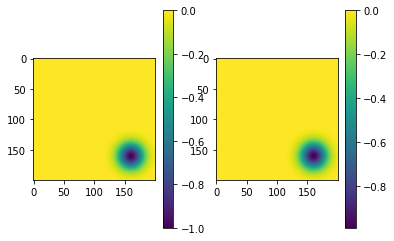

In [180]:
plt.subplot(1,2,1)
plot_2d_f(torch_mod_to_fcn(true_bf), n_smps_per_dim=200)
plt.subplot(1,2,2)
plot_2d_f(torch_mod_to_fcn(fit_bf), n_smps_per_dim=200)

# Now we look at fitting more complicated functions 

In [249]:
fcn_generator = FunctionSequenceGenerator(n_bumps = 50, bump_peak_vl_range = [-1, 1], cov_ev_range = [.01, .01])
f_true = fcn_generator.generate(1)

x = np.random.rand(10000,2)
y = f_true(x)

x = torch.tensor(x, dtype=torch.float32)
y = torch.tensor(y, dtype=torch.float32)

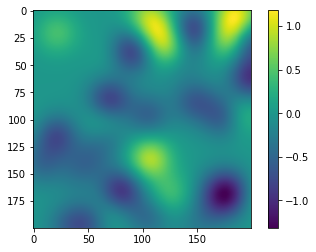

In [250]:
plot_2d_f(f_true, n_smps_per_dim=200)

## Fit a new sum of bump functions to the data

In [264]:
run_on_gpu = False

In [276]:
fit_sf = SumOfBumpFcns(50,support_p=.01, bandwidth_range=np.asarray([[5, 5], [5, 5]]), 
                       mag_range=np.asarray([0, 0.0]), d=2)

In [278]:
if run_on_gpu:
    fit_sf = fit_sf.to('cuda')
    x = x.to('cuda')
    y = y.to('cuda')
else:
    fit_bf = fit_bf.to('cpu')
    x = x.to('cpu')
    y = y.to('cpu')

In [279]:
lr = .01
center_k = 0 #.001
mag_k = 0# .0001
bandwidth_k = 0 #.0001
enforce_bounds=True
batch_size = 1000

t0 = time.time()

fit(fit_sf, x, y, n_its = 1001, lr=lr, batch_size=batch_size, center_k=center_k, mag_k=mag_k, 
    bandwidth_k=bandwidth_k, enforce_bounds=enforce_bounds, 
    update_int=100)
    
t_stop = time.time()

print('Elapsed time: ' + str(t_stop - t0))

It 0: 1.660510e-01
It 100: 3.375578e-02
It 200: 8.795505e-03
It 300: 3.189585e-03
It 400: 1.666510e-03
It 500: 9.696553e-04
It 600: 7.152710e-04
It 700: 6.136612e-04
It 800: 5.274132e-04
It 900: 5.553333e-04
It 1000: 4.085744e-04
Elapsed time: 21.941213130950928


In [280]:
fit_sf = fit_sf.to('cpu') 
x = x.to('cpu')
y = y.to('cpu')

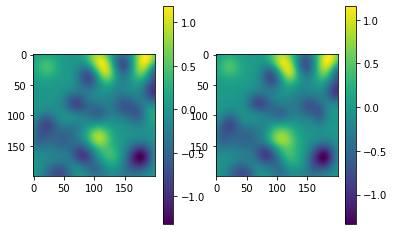

In [281]:
plt.subplot(1,2,1)
plot_2d_f(f_true, n_smps_per_dim=200)
plt.subplot(1,2,2)
plot_2d_f(torch_mod_to_fcn(fit_sf), n_smps_per_dim=200)